In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width: 98% !important }</style>'))

In [2]:
import joblib
from datetime import timedelta
import pandas as pd
from sklearn.preprocessing import normalize
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

pd.set_option('display.max_rows', 10000)

In [3]:
from utilities import *

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
ble = read_ble('../Data/ble.csv')
pin = read_pin('../Data/pin.csv')
test_pin = read_pin('../Data/testPin.csv')

In [6]:
def read_sequence_rssi(filename):
    rssi = pd.read_csv(filename)
    rssi = rssi.pivot_table(columns="scanner", values="rssi", index="time")
    rssi.rename_axis(None, axis=1, inplace=True)
    rssi.index = pd.to_datetime(rssi.index)
    rssi = rssi.groupby(pd.Grouper(freq='100ms')).mean()
    return rssi

def read_sequence_loc(filename):
    loc = pd.read_csv(filename)
    loc['time'] = pd.to_datetime(loc['time'])
    loc.set_index('time', inplace=True)
    loc = loc.groupby(pd.Grouper(freq='100ms')).mean()
    return loc

In [7]:
rssi = read_sequence_rssi('../Data/sequenceRssi_2.csv')
loc = read_sequence_loc('../Data/sequenceLoc_2.csv')

In [8]:
loc.isna().sum()

X    4197
Y    4197
dtype: int64

In [9]:
def transform(loc, inplace=False):
    if inplace:
        loc['X'] = 24.187023 + loc['X']
        loc['Y'] = 12.252072 - loc['Y']
    else:
        transformed = pd.DataFrame()
        transformed['X'] = 24.187023 + loc['X']
        transformed['Y'] = 12.252072 - loc['Y']
        return transformed

In [10]:
transform(loc, inplace=True)

In [11]:
def show_loc(ori_loc):
    img =  mpimg.imread('../Map/main.png')
    plt.figure(figsize=(40,40))
    plt.imshow(img)
    plt.scatter(ori_loc['X'] * 44, ori_loc['Y'] * 44, alpha=0.2)
    plt.show()

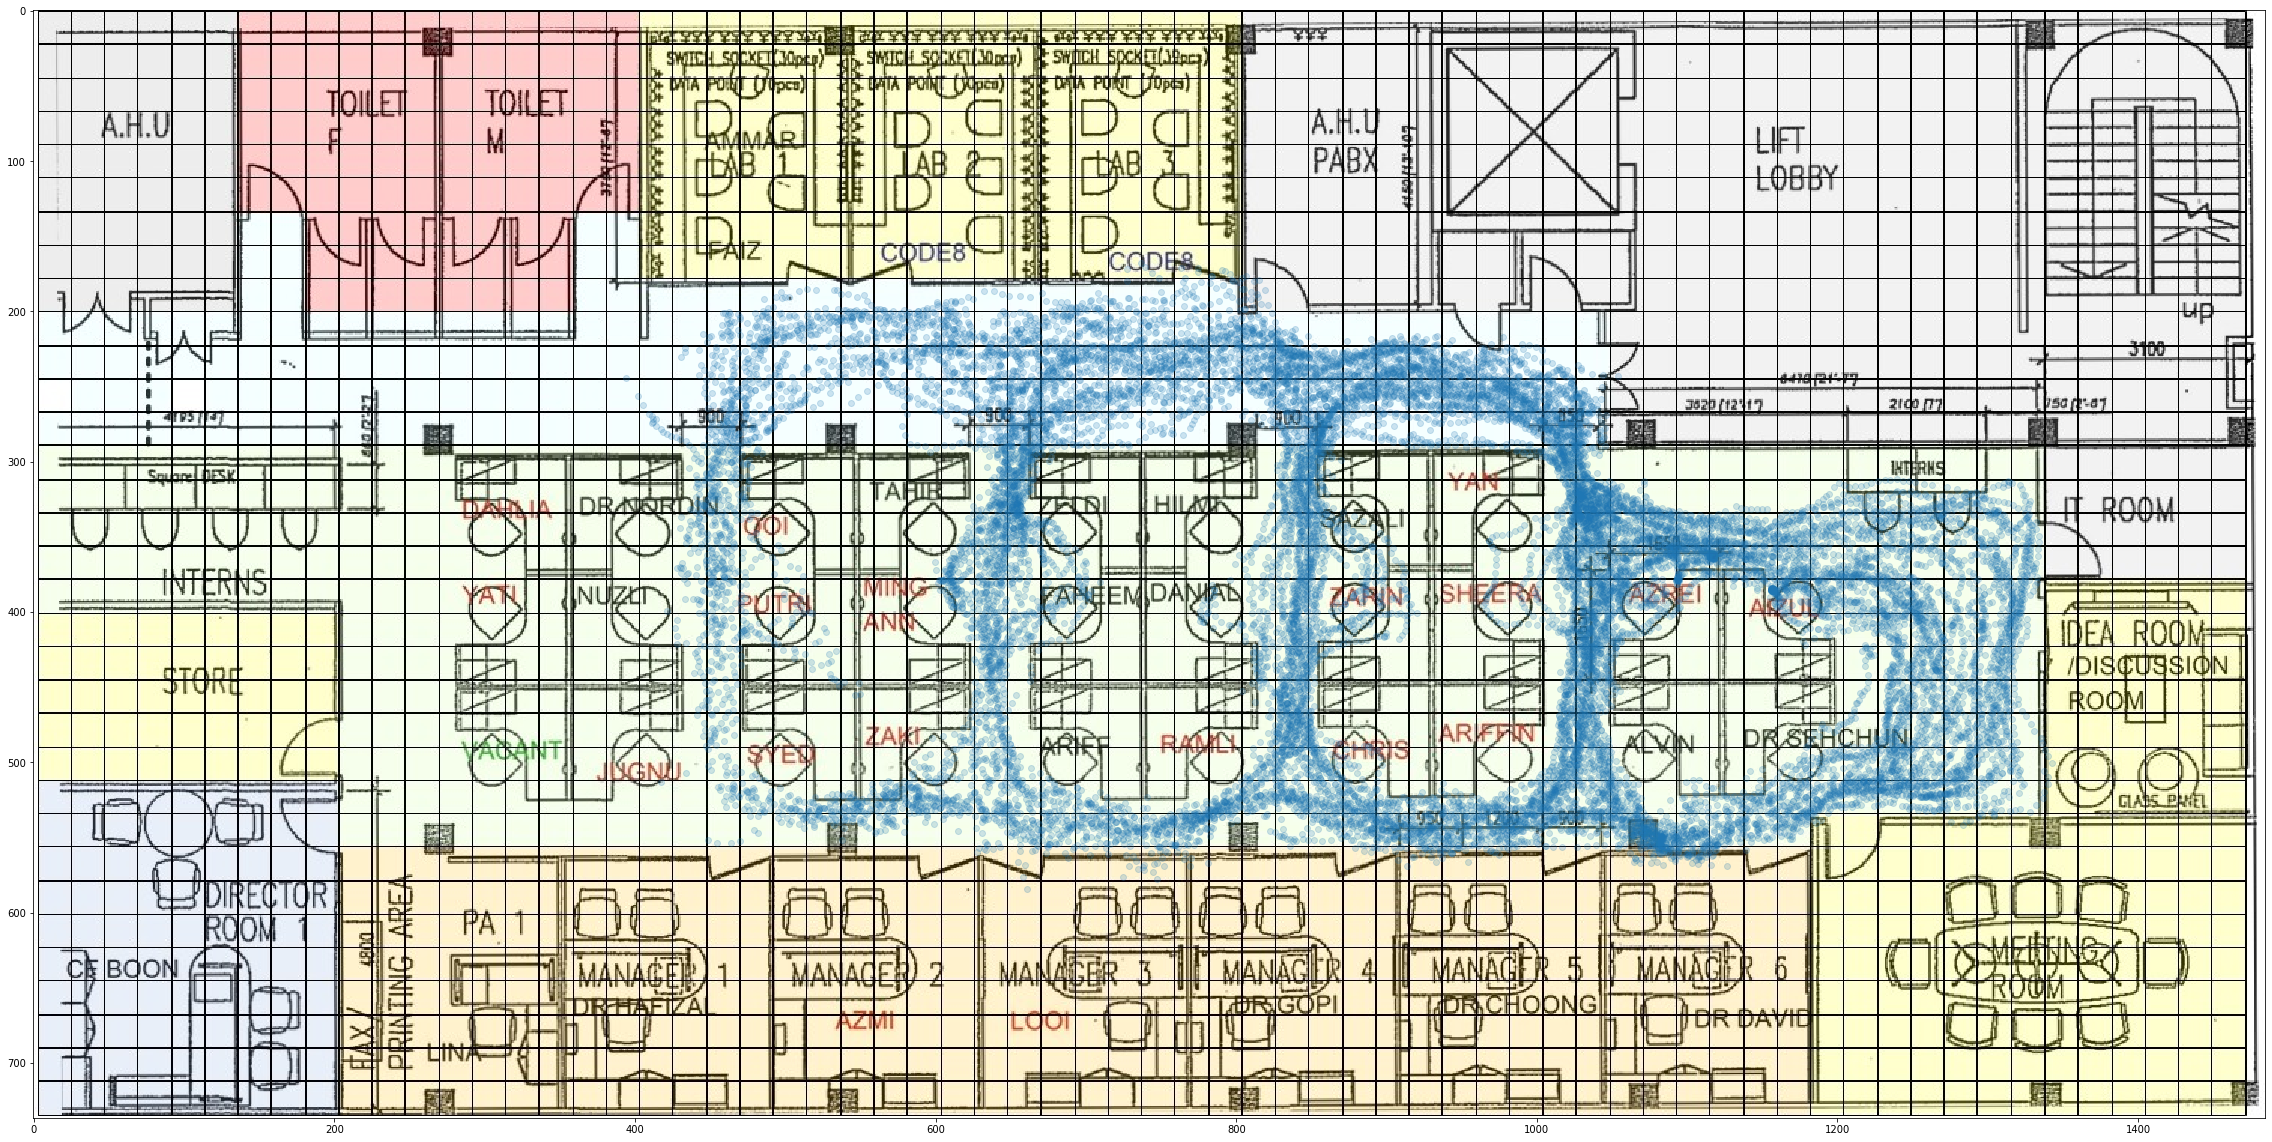

In [12]:
show_loc(loc)

In [13]:
data = rssi.join(loc, how='inner')
data.shape

(24099, 19)

In [14]:
data.isna().sum()

C400A2E19293    22734
CD4533FFC0E1    21704
D2B6503554D7    22246
DB8B36A69C56    22493
DD697EA75B68    22505
DF231643E227    21095
E13B805C6CB0    21136
E43355CA8B96    23051
E6D9D20DD197    22949
E8FD0B453DC4    23183
E96AF2C858BA    20109
EC72840D9AD3    21807
F1307ECB3B90    22149
F1EDAF28E08A    23141
F69A86823B96    21546
FB2EE01C18CE    21883
FDAE5980F28C    22801
X                4197
Y                4197
dtype: int64

In [15]:
def read_stationary_data(filename, number):
    data = read_data(filename)
    data = data.set_index('time').groupby([pd.Grouper('location'), pd.Grouper(freq='100ms')]).mean()
    data = data.groupby('location').tail(number)
    data = data.reset_index(0)
    data["X"] = data["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data["Y"] = data["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    return data[scanners + ['X', 'Y']]

In [16]:
stationary_data_1 = read_stationary_data('../Data/rssi5.csv', 2000)
stationary_data_2 = read_stationary_data('../Data/rssi_2.csv', 2000)

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [17]:
data = pd.concat([stationary_data_1, stationary_data_2, data], axis=0, sort=True)
data.sort_index(inplace=True)

In [18]:
data.describe()

C400A2E19293  CD4533FFC0E1  D2B6503554D7  DB8B36A69C56  DD697EA75B68  \
count   7945.000000   8739.000000   7163.000000   9186.000000   8005.000000   
mean     -73.664233    -74.254692    -76.867607    -73.414235    -72.866115   
std        8.827585      7.606913      7.254287      8.779032      6.954490   
min      -98.000000    -98.000000    -98.000000    -98.000000    -98.000000   
25%      -80.000000    -80.000000    -82.000000    -80.000000    -77.000000   
50%      -72.000000    -74.000000    -77.000000    -73.000000    -72.000000   
75%      -68.000000    -69.000000    -72.000000    -66.000000    -67.000000   
max      -46.000000    -48.000000    -51.000000    -52.000000    -50.000000   

       DF231643E227  E13B805C6CB0  E43355CA8B96  E6D9D20DD197  E8FD0B453DC4  \
count  10505.000000  10608.000000   8363.000000  11714.000000   5562.000000   
mean     -73.318694    -74.490056    -75.005148    -76.736908    -78.934781   
std        8.691612      8.892406      9.009628     11.377869      9.809546   
min      -98.000000    -98.000000    -98.000000    -98.000000    -98.000000   
25%      -80.000000    -81.000000    -82.000000    -86.000000    -87.000000   
50%      -72.000000    -75.000000    -74.000000    -77.000000    -80.000000   
75%      -66.000000    -68.000000    -68.000000    -70.000000    -72.000000   
max      -45.000000    -46.000000    -55.000000    -49.000000    -58.000000   

       E96AF2C858BA  EC72840D9AD3  F1307ECB3B90  F1EDAF28E08A  F69A86823B96  \
count  11547.000000   8948.000000  10463.000000   8599.000000   9754.000000   
mean     -76.157446    -72.308033    -69.209014    -77.927076    -74.650263   
std       10.082311      7.734545      7.918597      9.629395      8.491913   
min      -98.000000    -97.000000    -96.000000    -98.000000    -98.000000   
25%      -84.000000    -77.000000    -75.000000    -87.000000    -80.666667   
50%      -75.500000    -72.000000    -68.000000    -77.000000    -75.000000   
75%      -67.000000    -67.000000    -64.000000    -71.000000    -69.000000   
max      -50.000000    -48.000000    -51.000000    -57.000000    -52.000000   

       FB2EE01C18CE  FDAE5980F28C             X             Y  
count   6626.000000   7769.000000  70678.000000  70678.000000  
mean     -82.276580    -75.767849     18.130715      8.516718  
std        8.044067      8.451442      7.338159      2.694040  
min      -98.000000    -98.000000      5.180690      3.809928  
25%      -89.000000    -82.000000     11.176600      5.312350  
50%      -83.000000    -75.000000     18.708656      8.203950  
75%      -75.000000    -69.000000     23.244200     11.717700  
max      -62.000000    -48.000000     30.512491     13.279880

In [19]:
test_rssi = read_sequence_rssi('../Data/testSequenceRssi_2.csv')
test_loc = read_sequence_loc('../Data/testSequenceLoc_2.csv')

In [20]:
test_loc.isna().sum()

X    1152
Y    1152
dtype: int64

In [21]:
transform(test_loc, inplace=True)

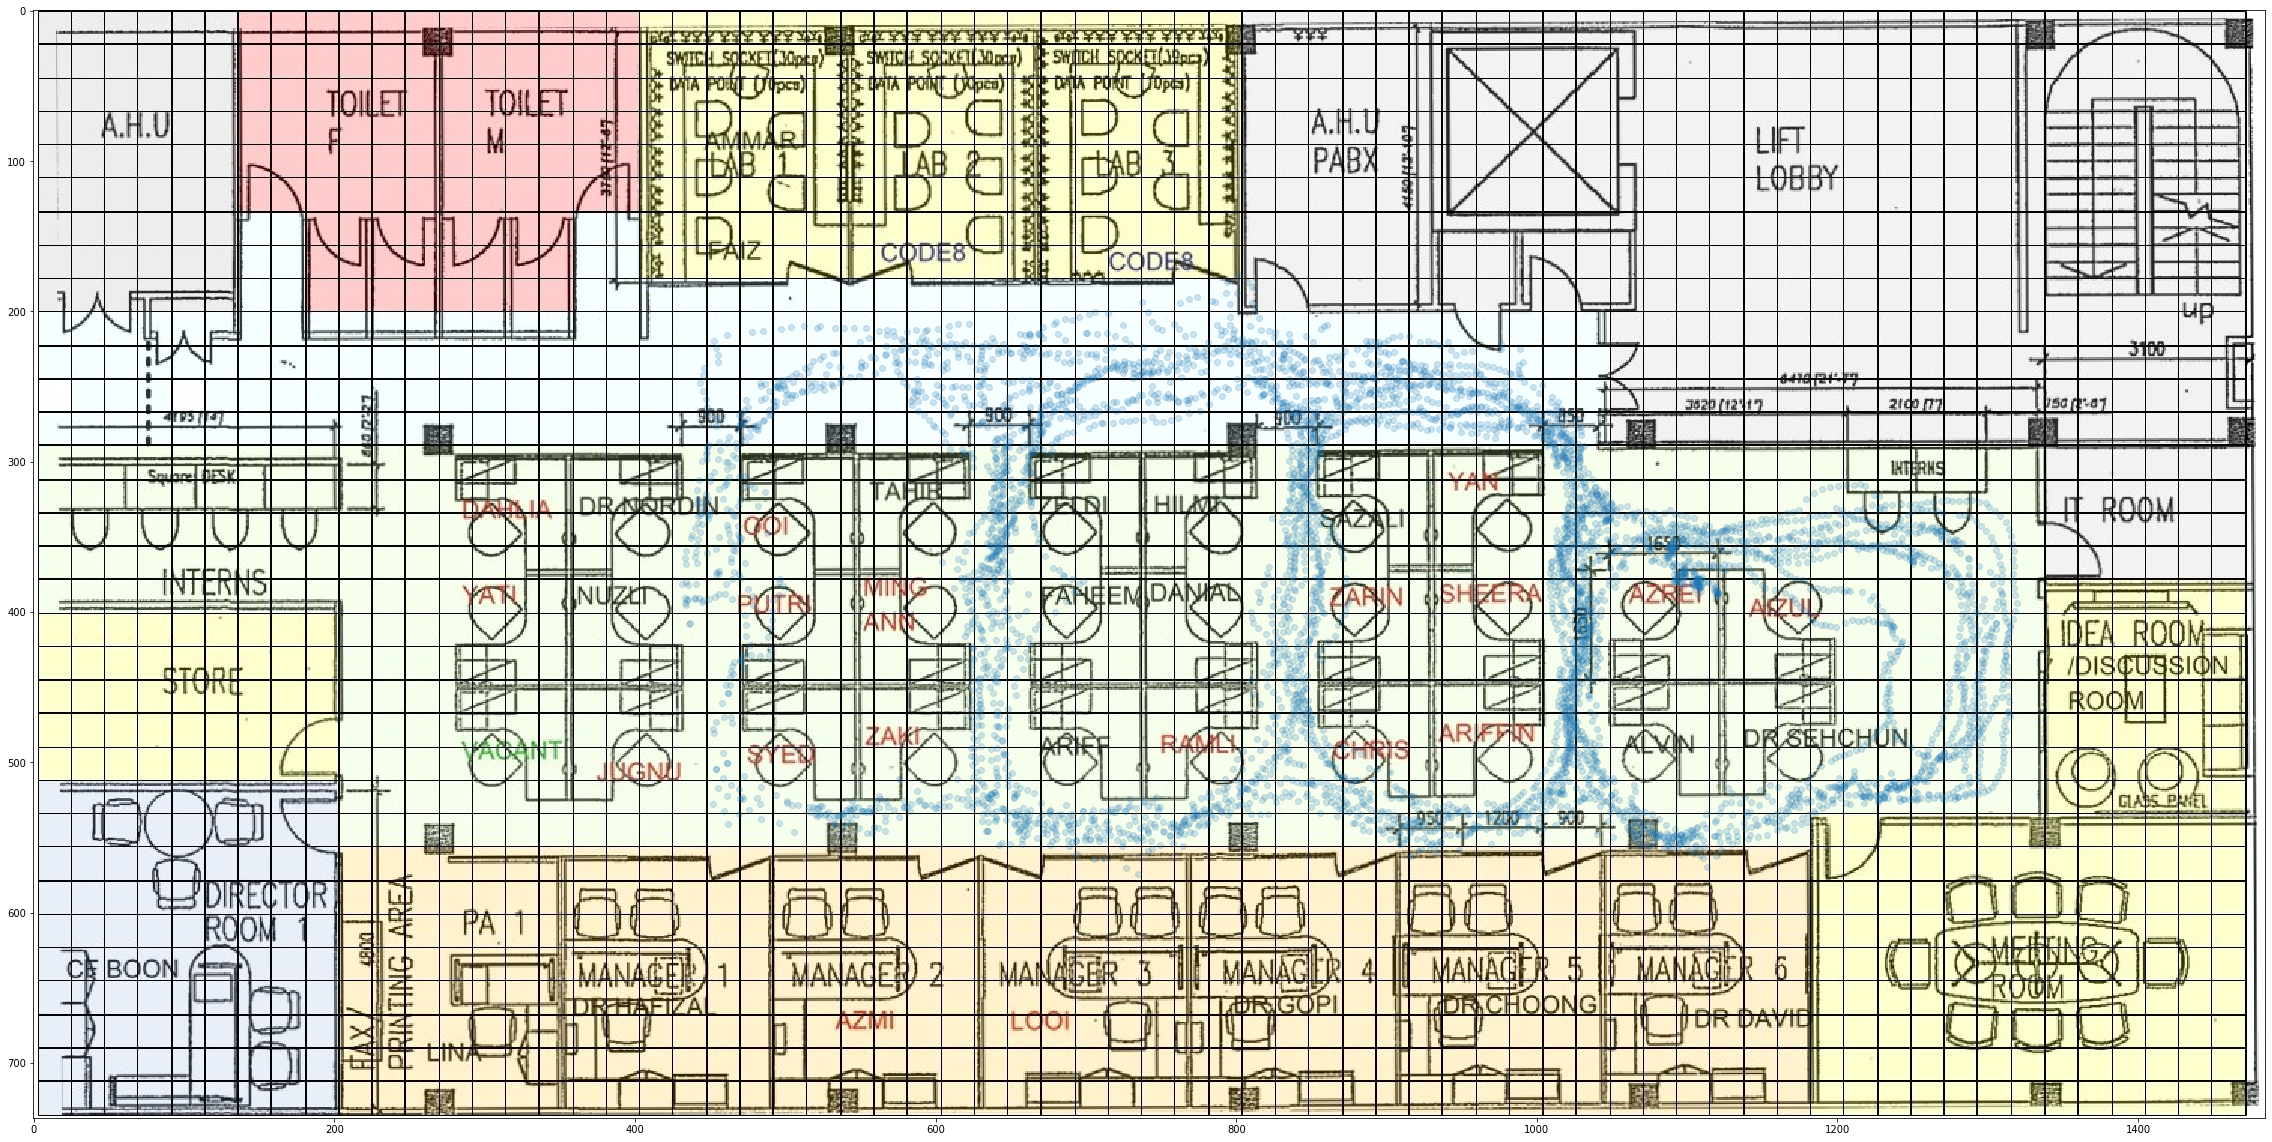

In [22]:
show_loc(test_loc)

In [23]:
test = test_rssi.join(test_loc, how='inner')
test.shape

(6373, 18)

In [24]:
test.isna().sum()

C400A2E19293    6070
CD4533FFC0E1    5894
D2B6503554D7    6030
DB8B36A69C56    5979
DD697EA75B68    6035
DF231643E227    5730
E13B805C6CB0    5748
E43355CA8B96    6105
E6D9D20DD197    6269
E8FD0B453DC4    6129
EC72840D9AD3    5878
F1307ECB3B90    5968
F1EDAF28E08A    6100
F69A86823B96    5772
FB2EE01C18CE    5903
FDAE5980F28C    6083
X               1152
Y               1152
dtype: int64

In [25]:
stationary_test_1 = read_stationary_data('../Data/testRssi.csv', 500)
stationary_test_2 = read_stationary_data('../Data/testRssi_2.csv', 500)

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [26]:
test = pd.concat([stationary_test_1, stationary_test_2, test], axis=0, sort=True)
test.sort_index(inplace=True)

In [27]:
test.describe()

C400A2E19293  CD4533FFC0E1  D2B6503554D7  DB8B36A69C56  DD697EA75B68  \
count   1911.000000   2053.000000   1723.000000   2033.000000   2098.000000   
mean     -74.064233    -74.359149    -77.073902    -75.845384    -72.718939   
std        9.338481      8.137388      6.632986      7.585884      7.956749   
min      -96.000000    -96.000000    -96.000000    -98.000000    -97.000000   
25%      -82.000000    -79.000000    -81.000000    -81.000000    -77.000000   
50%      -72.000000    -74.000000    -77.000000    -75.000000    -72.000000   
75%      -67.000000    -69.000000    -73.000000    -71.000000    -67.000000   
max      -51.000000    -52.000000    -50.000000    -53.000000    -52.000000   

       DF231643E227  E13B805C6CB0  E43355CA8B96  E6D9D20DD197  E8FD0B453DC4  \
count   2742.000000   2438.000000   1889.000000   2119.000000   1455.000000   
mean     -70.105762    -74.167692    -76.271793    -80.169616    -79.356472   
std        9.939048      8.067441      8.953170      7.462163     10.278085   
min      -98.000000    -98.000000    -98.000000    -97.000000    -98.000000   
25%      -78.000000    -80.000000    -84.000000    -87.000000    -88.000000   
50%      -68.000000    -73.000000    -75.000000    -80.000000    -80.000000   
75%      -63.000000    -67.000000    -68.000000    -73.000000    -70.000000   
max      -46.000000    -49.000000    -61.000000    -62.000000    -56.000000   

       E96AF2C858BA  EC72840D9AD3  F1307ECB3B90  F1EDAF28E08A  F69A86823B96  \
count   1984.000000   2210.000000   2287.000000   1943.000000   2211.000000   
mean     -76.771791    -72.697587    -71.239980    -77.287365    -76.781087   
std        8.937056      7.640263      7.360933     10.437763      8.126054   
min      -98.000000    -94.000000    -97.000000    -98.000000    -98.000000   
25%      -84.000000    -78.000000    -76.000000    -87.000000    -83.000000   
50%      -74.000000    -73.000000    -70.000000    -75.000000    -76.000000   
75%      -69.875000    -68.000000    -66.000000    -68.000000    -71.000000   
max      -62.000000    -51.000000    -51.000000    -61.000000    -51.000000   

       FB2EE01C18CE  FDAE5980F28C             X             Y  
count   1694.000000   1823.000000  16765.000000  16765.000000  
mean     -82.477322    -75.445703     18.105762      8.952524  
std        7.607242      8.851790      6.993089      2.472859  
min      -97.000000    -98.000000      5.626103      3.998992  
25%      -89.000000    -81.000000     12.717952      6.570950  
50%      -83.500000    -75.000000     18.790348      9.659024  
75%      -76.000000    -70.000000     23.355726     11.139202  
max      -66.000000    -48.000000     29.985628     13.048461

In [28]:
def impute(data):
    data.update(data.rolling('5s').mean())
    data.ffill(inplace=True)

In [29]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        ss.index = data.index
        data[s].fillna(ss, inplace=True)

In [30]:
impute(data)
linear_impute(data)
data[scanners] = normalize(data[scanners] + 100)

In [31]:
data

C400A2E19293  CD4533FFC0E1  D2B6503554D7  \
time                                                                
2019-12-02 01:05:32.900      0.123489      0.245433      0.211643   
2019-12-02 01:05:33.000      0.118123      0.234767      0.202445   
2019-12-02 01:05:33.100      0.113944      0.226462      0.195284   
2019-12-02 01:05:33.300      0.111135      0.220878      0.190468   
2019-12-02 01:05:33.400      0.111075      0.220759      0.190366   
...                               ...           ...           ...   
2020-02-19 02:08:59.900      0.148489      0.341036      0.205601   
2020-02-19 02:09:00.000      0.148835      0.341830      0.206079   
2020-02-19 02:09:00.100      0.148862      0.341891      0.206116   
2020-02-19 02:09:00.200      0.148917      0.342019      0.206193   
2020-02-19 02:09:00.300      0.150354      0.349861      0.208182   

                         DB8B36A69C56  DD697EA75B68  DF231643E227  \
time                                                                
2019-12-02 01:05:32.900      0.166112      0.218902      0.347232   
2019-12-02 01:05:33.000      0.158893      0.209388      0.332142   
2019-12-02 01:05:33.100      0.153272      0.201981      0.320393   
2019-12-02 01:05:33.300      0.149492      0.197001      0.312492   
2019-12-02 01:05:33.400      0.149412      0.196895      0.312325   
...                               ...           ...           ...   
2020-02-19 02:08:59.900      0.217023      0.236060      0.412343   
2020-02-19 02:09:00.000      0.217528      0.220390      0.413304   
2020-02-19 02:09:00.100      0.211841      0.220430      0.416396   
2020-02-19 02:09:00.200      0.211921      0.220512      0.416552   
2020-02-19 02:09:00.300      0.213965      0.222639      0.420990   

                         E13B805C6CB0  E43355CA8B96  E6D9D20DD197  \
time                                                                
2019-12-02 01:05:32.900      0.330311      0.049953      0.322956   
2019-12-02 01:05:33.000      0.315956      0.047782      0.334474   
2019-12-02 01:05:33.100      0.304779      0.046092      0.322642   
2019-12-02 01:05:33.300      0.297264      0.044955      0.314686   
2019-12-02 01:05:33.400      0.297105      0.044931      0.314517   
...                               ...           ...           ...   
2020-02-19 02:08:59.900      0.339812      0.131356      0.214738   
2020-02-19 02:09:00.000      0.340603      0.131662      0.215238   
2020-02-19 02:09:00.100      0.340664      0.131685      0.215022   
2020-02-19 02:09:00.200      0.340792      0.131735      0.213353   
2020-02-19 02:09:00.300      0.346970      0.133005      0.222318   

                         E8FD0B453DC4  E96AF2C858BA  EC72840D9AD3  \
time                                                                
2019-12-02 01:05:32.900      0.034190      0.409756      0.201994   
2019-12-02 01:05:33.000      0.032704      0.391948      0.193216   
2019-12-02 01:05:33.100      0.031548      0.460917      0.186381   
2019-12-02 01:05:33.300      0.030770      0.421454      0.325925   
2019-12-02 01:05:33.400      0.044931      0.421228      0.325750   
...                               ...           ...           ...   
2020-02-19 02:08:59.900      0.140874      0.272230      0.285556   
2020-02-19 02:09:00.000      0.141203      0.281017      0.286221   
2020-02-19 02:09:00.100      0.141228      0.280547      0.286272   
2020-02-19 02:09:00.200      0.141281      0.280652      0.286380   
2020-02-19 02:09:00.300      0.142643      0.283359      0.289141   

                         F1307ECB3B90  F1EDAF28E08A  F69A86823B96  \
time                                                                
2019-12-02 01:05:32.900      0.224788      0.005864      0.316069   
2019-12-02 01:05:33.000      0.232937      0.005609      0.302333   
2019-12-02 01:05:33.100      0.224697      0.005411      0.291638   
2019-12-02 01:05:33.300      0.219156      0.005277      0.284447   
2019-12-02 01:05:33

In [32]:
impute(test)
linear_impute(test)
test[scanners] = normalize(test[scanners] + 100)

In [33]:
test.describe()

C400A2E19293  CD4533FFC0E1  D2B6503554D7  DB8B36A69C56  DD697EA75B68  \
count  17917.000000  17917.000000  17917.000000  17917.000000  17917.000000   
mean       0.234376      0.261034      0.237804      0.241042      0.271703   
std        0.086700      0.078186      0.061770      0.065999      0.069747   
min        0.067921      0.038731      0.037366      0.048598      0.038500   
25%        0.158077      0.217613      0.201371      0.195831      0.231768   
50%        0.229584      0.268225      0.237890      0.241462      0.276042   
75%        0.305838      0.313749      0.269248      0.281885      0.319692   
max        0.459777      0.455675      0.495996      0.435657      0.466405   

       DF231643E227  E13B805C6CB0  E43355CA8B96  E6D9D20DD197  E8FD0B453DC4  \
count  17917.000000  17917.000000  17917.000000  17917.000000  17917.000000   
mean       0.285121      0.250859      0.203062      0.143546      0.167941   
std        0.109634      0.089770      0.089193      0.076050      0.098153   
min        0.031367      0.034582      0.024384      0.037425      0.021091   
25%        0.191640      0.184005      0.134846      0.098390      0.101615   
50%        0.269956      0.244364      0.191666      0.120446      0.140362   
75%        0.380045      0.320639      0.267921      0.175033      0.211802   
max        0.542102      0.503287      0.454747      0.425417      0.510659   

       E96AF2C858BA  EC72840D9AD3  F1307ECB3B90  F1EDAF28E08A  F69A86823B96  \
count  17917.000000  17917.000000  17917.000000  17917.000000  17917.000000   
mean       0.140535      0.276561      0.294292      0.152925      0.237266   
std        0.107382      0.055679      0.059813      0.108895      0.081412   
min        0.031231      0.065599      0.037322      0.007093      0.021191   
25%        0.054694      0.241309      0.253835      0.068870      0.186806   
50%        0.088680      0.271476      0.300916      0.120661      0.234993   
75%        0.238891      0.312561      0.340339      0.200775      0.307372   
max        0.423035      0.458778      0.454442      0.455271      0.451071   

       FB2EE01C18CE  FDAE5980F28C             X             Y  
count  17917.000000  17917.000000  17917.000000  17917.000000  
mean       0.148105      0.219257     18.042361      8.972346  
std        0.084999      0.087310      6.838857      2.428421  
min        0.028069      0.021282      5.626103      4.554205  
25%        0.076400      0.153490     12.717952      6.593112  
50%        0.121911      0.222342     18.790348      9.659024  
75%        0.205117      0.277491     23.355726     11.087109  
max        0.401597      0.420113     29.934250     12.450004

In [34]:
def create_window(dataset, win_size, start_index=0, end_index=None):
    data = []
    labels = []

    start_index = start_index + win_size
    if end_index is None:
        end_index = len(dataset)

    for i in range(start_index, end_index, win_size):
        indices = range(i-win_size, i)
        slices = dataset.iloc[indices]
        if slices.index.max() - slices.index.min() < timedelta(milliseconds=win_size * 200):
            data.append(slices[scanners].values)
            labels.append(slices[['X', 'Y']].values)
    return np.array(data), np.array(labels)

In [35]:
win_size = 10
X, y = create_window(data, win_size)

In [36]:
X.shape

(7416, 10, 17)

In [37]:
X_test, y_test = create_window(test, win_size)

In [38]:
msk = np.random.rand(len(X)) < 0.8
X_train, y_train = X[msk], y[msk]
X_validation, y_validation = X[~msk], y[~msk]

In [39]:
X_train.shape

(5909, 10, 17)

In [40]:
batch_size = 32
ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds = ds.batch(batch_size).repeat()

In [41]:
ds_validation = tf.data.Dataset.from_tensor_slices((X_validation, y_validation))
ds_validation = ds_validation.batch(batch_size)

In [42]:
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
ds_test = ds_test.batch(batch_size)

In [43]:
epochs = 50000

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=80, monitor='val_mse')
]

metrics = ['mae', 'mse']

inputs = tf.keras.Input(shape=(win_size, 17))

lstm = tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)(inputs)

x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(lstm)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(1)(x)

y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(lstm)
y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(1)(y)

outputs = tf.keras.layers.Concatenate(axis=2)([x, y])

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(0.00001)
model.compile(optimizer=optimizer, loss='mse', metrics=metrics)

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 17)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 10, 128)      74752       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 10, 128)      131584      lstm[0][0]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 10, 128)      16512       lstm_1[0][0]                     
______________________________________________________________________________________________

In [45]:
history = model.fit(ds, epochs=epochs, steps_per_epoch=X_train.shape[0] // batch_size, validation_data=ds_validation, callbacks=callbacks)

Train for 184 steps, validate for 48 steps
Epoch 1/50000
184/184 [==============================] - 5s 28ms/step - loss: 229.8774 - mae: 13.3054 - mse: 229.3266 - val_loss: 231.2278 - val_mae: 13.3225 - val_mse: 230.0396
Epoch 2/50000
184/184 [==============================] - 2s 12ms/step - loss: 229.7531 - mae: 13.2908 - mse: 229.0915 - val_loss: 230.5236 - val_mae: 13.2960 - val_mse: 229.3463
Epoch 3/50000
184/184 [==============================] - 2s 12ms/step - loss: 228.2153 - mae: 13.2400 - mse: 227.5613 - val_loss: 228.9906 - val_mae: 13.2377 - val_mse: 227.8253
Epoch 4/50000
184/184 [==============================] - 2s 13ms/step - loss: 225.7149 - mae: 13.1372 - mse: 225.0677 - val_loss: 223.3964 - val_mae: 13.0205 - val_mse: 222.2518
Epoch 5/50000
184/184 [==============================] - 2s 12ms/step - loss: 202.7917 - mae: 12.1878 - mse: 202.1216 - val_loss: 170.5097 - val_mae: 10.7935 - val_mse: 169.5996
Epoch 6/50000
184/184 [==============================] - 2s 12ms/st

Epoch 48/50000
184/184 [==============================] - 2s 11ms/step - loss: 20.1332 - mae: 2.9921 - mse: 19.7769 - val_loss: 20.2259 - val_mae: 3.0433 - val_mse: 19.8352
Epoch 49/50000
184/184 [==============================] - 2s 11ms/step - loss: 19.6521 - mae: 2.9622 - mse: 19.2978 - val_loss: 19.7177 - val_mae: 3.0158 - val_mse: 19.3284
Epoch 50/50000
184/184 [==============================] - 2s 11ms/step - loss: 19.0712 - mae: 2.9274 - mse: 18.7188 - val_loss: 19.2140 - val_mae: 2.9876 - val_mse: 18.8262
Epoch 51/50000
184/184 [==============================] - 2s 11ms/step - loss: 18.5961 - mae: 2.8966 - mse: 18.2456 - val_loss: 18.7083 - val_mae: 2.9585 - val_mse: 18.3225
Epoch 52/50000
184/184 [==============================] - 2s 11ms/step - loss: 18.0285 - mae: 2.8625 - mse: 17.6796 - val_loss: 18.2047 - val_mae: 2.9290 - val_mse: 17.8208
Epoch 53/50000
184/184 [==============================] - 2s 11ms/step - loss: 17.5636 - mae: 2.8334 - mse: 17.2166 - val_loss: 17.7065

184/184 [==============================] - 2s 11ms/step - loss: 5.6701 - mae: 1.8716 - mse: 5.3629 - val_loss: 5.6387 - val_mae: 1.8726 - val_mse: 5.3123
Epoch 144/50000
184/184 [==============================] - 2s 11ms/step - loss: 5.6440 - mae: 1.8672 - mse: 5.3368 - val_loss: 5.6271 - val_mae: 1.8709 - val_mse: 5.3001
Epoch 145/50000
184/184 [==============================] - 2s 11ms/step - loss: 5.5976 - mae: 1.8598 - mse: 5.2904 - val_loss: 5.6229 - val_mae: 1.8701 - val_mse: 5.2949
Epoch 146/50000
184/184 [==============================] - 2s 11ms/step - loss: 5.5636 - mae: 1.8541 - mse: 5.2565 - val_loss: 5.6208 - val_mae: 1.8700 - val_mse: 5.2919
Epoch 147/50000
184/184 [==============================] - 2s 11ms/step - loss: 5.5392 - mae: 1.8501 - mse: 5.2321 - val_loss: 5.6178 - val_mae: 1.8701 - val_mse: 5.2881
Epoch 148/50000
184/184 [==============================] - 2s 11ms/step - loss: 5.5611 - mae: 1.8546 - mse: 5.2542 - val_loss: 5.6123 - val_mae: 1.8702 - val_mse: 5.2

184/184 [==============================] - 2s 11ms/step - loss: 3.4811 - mae: 1.4036 - mse: 3.1746 - val_loss: 3.6271 - val_mae: 1.4441 - val_mse: 3.2898
Epoch 240/50000
184/184 [==============================] - 2s 11ms/step - loss: 3.4730 - mae: 1.4014 - mse: 3.1665 - val_loss: 3.6049 - val_mae: 1.4396 - val_mse: 3.2680
Epoch 241/50000
184/184 [==============================] - 2s 11ms/step - loss: 3.4545 - mae: 1.3959 - mse: 3.1480 - val_loss: 3.5855 - val_mae: 1.4356 - val_mse: 3.2490
Epoch 242/50000
184/184 [==============================] - 2s 11ms/step - loss: 3.4484 - mae: 1.3947 - mse: 3.1419 - val_loss: 3.5586 - val_mae: 1.4299 - val_mse: 3.2230
Epoch 243/50000
184/184 [==============================] - 2s 11ms/step - loss: 3.4347 - mae: 1.3909 - mse: 3.1281 - val_loss: 3.5346 - val_mae: 1.4247 - val_mse: 3.2001
Epoch 244/50000
184/184 [==============================] - 2s 11ms/step - loss: 3.4333 - mae: 1.3906 - mse: 3.1267 - val_loss: 3.5140 - val_mae: 1.4205 - val_mse: 3.1

184/184 [==============================] - 2s 11ms/step - loss: 2.8958 - mae: 1.2481 - mse: 2.5897 - val_loss: 3.0927 - val_mae: 1.2940 - val_mse: 2.7541
Epoch 336/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.8904 - mae: 1.2463 - mse: 2.5843 - val_loss: 3.0910 - val_mae: 1.2933 - val_mse: 2.7525
Epoch 337/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.8883 - mae: 1.2458 - mse: 2.5823 - val_loss: 3.0839 - val_mae: 1.2913 - val_mse: 2.7458
Epoch 338/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.8818 - mae: 1.2448 - mse: 2.5757 - val_loss: 3.0710 - val_mae: 1.2879 - val_mse: 2.7336
Epoch 339/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.8746 - mae: 1.2424 - mse: 2.5685 - val_loss: 3.0546 - val_mae: 1.2836 - val_mse: 2.7181
Epoch 340/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.8749 - mae: 1.2431 - mse: 2.5688 - val_loss: 3.0333 - val_mae: 1.2785 - val_mse: 2.6

184/184 [==============================] - 2s 11ms/step - loss: 2.6008 - mae: 1.1699 - mse: 2.2953 - val_loss: 2.7024 - val_mae: 1.2009 - val_mse: 2.3773
Epoch 432/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.6038 - mae: 1.1713 - mse: 2.2983 - val_loss: 2.7221 - val_mae: 1.2055 - val_mse: 2.3988
Epoch 433/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.6024 - mae: 1.1711 - mse: 2.2968 - val_loss: 2.7499 - val_mae: 1.2122 - val_mse: 2.4290
Epoch 434/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.6005 - mae: 1.1710 - mse: 2.2950 - val_loss: 2.7900 - val_mae: 1.2220 - val_mse: 2.4719
Epoch 435/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.5894 - mae: 1.1667 - mse: 2.2839 - val_loss: 2.8513 - val_mae: 1.2371 - val_mse: 2.5364
Epoch 436/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.5816 - mae: 1.1647 - mse: 2.2760 - val_loss: 2.9211 - val_mae: 1.2538 - val_mse: 2.6

184/184 [==============================] - 2s 11ms/step - loss: 2.3721 - mae: 1.1051 - mse: 2.0668 - val_loss: 2.4901 - val_mae: 1.1313 - val_mse: 2.1550
Epoch 528/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.3567 - mae: 1.0998 - mse: 2.0514 - val_loss: 2.4719 - val_mae: 1.1267 - val_mse: 2.1378
Epoch 529/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.3643 - mae: 1.1014 - mse: 2.0590 - val_loss: 2.4624 - val_mae: 1.1242 - val_mse: 2.1285
Epoch 530/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.3601 - mae: 1.1003 - mse: 2.0548 - val_loss: 2.4573 - val_mae: 1.1229 - val_mse: 2.1235
Epoch 531/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.3570 - mae: 1.0996 - mse: 2.0517 - val_loss: 2.4514 - val_mae: 1.1215 - val_mse: 2.1175
Epoch 532/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.3641 - mae: 1.1029 - mse: 2.0588 - val_loss: 2.4401 - val_mae: 1.1187 - val_mse: 2.1

184/184 [==============================] - 2s 12ms/step - loss: 2.1711 - mae: 1.0431 - mse: 1.8660 - val_loss: 2.6495 - val_mae: 1.1654 - val_mse: 2.3357
Epoch 624/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.1824 - mae: 1.0471 - mse: 1.8773 - val_loss: 2.6801 - val_mae: 1.1716 - val_mse: 2.3679
Epoch 625/50000
184/184 [==============================] - 2s 12ms/step - loss: 2.1733 - mae: 1.0436 - mse: 1.8682 - val_loss: 2.7131 - val_mae: 1.1781 - val_mse: 2.4027
Epoch 626/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.1699 - mae: 1.0430 - mse: 1.8648 - val_loss: 2.7462 - val_mae: 1.1839 - val_mse: 2.4381
Epoch 627/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.1621 - mae: 1.0406 - mse: 1.8570 - val_loss: 2.7856 - val_mae: 1.1906 - val_mse: 2.4805
Epoch 628/50000
184/184 [==============================] - 2s 11ms/step - loss: 2.1601 - mae: 1.0398 - mse: 1.8550 - val_loss: 2.8370 - val_mae: 1.2008 - val_mse: 2.5

184/184 [==============================] - 2s 12ms/step - loss: 2.0195 - mae: 0.9970 - mse: 1.7143 - val_loss: 2.1037 - val_mae: 1.0164 - val_mse: 1.7628
Epoch 720/50000
184/184 [==============================] - 2s 12ms/step - loss: 2.0176 - mae: 0.9962 - mse: 1.7125 - val_loss: 2.0963 - val_mae: 1.0145 - val_mse: 1.7558
Epoch 721/50000
184/184 [==============================] - 2s 12ms/step - loss: 2.0146 - mae: 0.9949 - mse: 1.7094 - val_loss: 2.0883 - val_mae: 1.0122 - val_mse: 1.7484
Epoch 722/50000
184/184 [==============================] - 2s 12ms/step - loss: 2.0043 - mae: 0.9916 - mse: 1.6992 - val_loss: 2.0813 - val_mae: 1.0102 - val_mse: 1.7420
Epoch 723/50000
184/184 [==============================] - 2s 13ms/step - loss: 2.0036 - mae: 0.9914 - mse: 1.6984 - val_loss: 2.0772 - val_mae: 1.0090 - val_mse: 1.7382
Epoch 724/50000
184/184 [==============================] - 2s 12ms/step - loss: 2.0104 - mae: 0.9943 - mse: 1.7052 - val_loss: 2.0738 - val_mae: 1.0080 - val_mse: 1.7

184/184 [==============================] - 2s 12ms/step - loss: 1.8526 - mae: 0.9431 - mse: 1.5469 - val_loss: 2.5260 - val_mae: 1.1109 - val_mse: 2.2175
Epoch 816/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.8652 - mae: 0.9466 - mse: 1.5596 - val_loss: 2.5673 - val_mae: 1.1213 - val_mse: 2.2604
Epoch 817/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.8632 - mae: 0.9462 - mse: 1.5575 - val_loss: 2.6058 - val_mae: 1.1311 - val_mse: 2.3002
Epoch 818/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.8596 - mae: 0.9447 - mse: 1.5539 - val_loss: 2.6460 - val_mae: 1.1410 - val_mse: 2.3416
Epoch 819/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.8589 - mae: 0.9447 - mse: 1.5532 - val_loss: 2.6832 - val_mae: 1.1497 - val_mse: 2.3796
Epoch 820/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.8620 - mae: 0.9460 - mse: 1.5564 - val_loss: 2.7197 - val_mae: 1.1580 - val_mse: 2.4

184/184 [==============================] - 2s 12ms/step - loss: 1.7484 - mae: 0.9058 - mse: 1.4430 - val_loss: 1.8211 - val_mae: 0.9205 - val_mse: 1.4767
Epoch 912/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.7442 - mae: 0.9042 - mse: 1.4388 - val_loss: 1.8210 - val_mae: 0.9210 - val_mse: 1.4775
Epoch 913/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.7413 - mae: 0.9031 - mse: 1.4359 - val_loss: 1.8230 - val_mae: 0.9226 - val_mse: 1.4805
Epoch 914/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.7423 - mae: 0.9034 - mse: 1.4369 - val_loss: 1.8250 - val_mae: 0.9247 - val_mse: 1.4842
Epoch 915/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.7347 - mae: 0.9002 - mse: 1.4294 - val_loss: 1.8296 - val_mae: 0.9281 - val_mse: 1.4911
Epoch 916/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.7405 - mae: 0.9024 - mse: 1.4352 - val_loss: 1.8377 - val_mae: 0.9325 - val_mse: 1.5

184/184 [==============================] - 2s 12ms/step - loss: 1.6477 - mae: 0.8687 - mse: 1.3444 - val_loss: 2.4280 - val_mae: 1.0741 - val_mse: 2.1213
Epoch 1008/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.6509 - mae: 0.8706 - mse: 1.3476 - val_loss: 2.4455 - val_mae: 1.0791 - val_mse: 2.1395
Epoch 1009/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.6503 - mae: 0.8702 - mse: 1.3471 - val_loss: 2.4642 - val_mae: 1.0844 - val_mse: 2.1589
Epoch 1010/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.6477 - mae: 0.8690 - mse: 1.3446 - val_loss: 2.4805 - val_mae: 1.0891 - val_mse: 2.1757
Epoch 1011/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.6455 - mae: 0.8681 - mse: 1.3424 - val_loss: 2.4932 - val_mae: 1.0931 - val_mse: 2.1890
Epoch 1012/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.6412 - mae: 0.8669 - mse: 1.3381 - val_loss: 2.5046 - val_mae: 1.0967 - val_mse

184/184 [==============================] - 2s 12ms/step - loss: 1.6071 - mae: 0.8537 - mse: 1.3055 - val_loss: 1.6896 - val_mae: 0.8682 - val_mse: 1.3466
Epoch 1056/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.6088 - mae: 0.8548 - mse: 1.3072 - val_loss: 1.6923 - val_mae: 0.8690 - val_mse: 1.3478
Epoch 1057/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.6065 - mae: 0.8536 - mse: 1.3050 - val_loss: 1.6984 - val_mae: 0.8710 - val_mse: 1.3525
Epoch 1058/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.6059 - mae: 0.8530 - mse: 1.3044 - val_loss: 1.7059 - val_mae: 0.8735 - val_mse: 1.3589
Epoch 1059/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.6038 - mae: 0.8522 - mse: 1.3024 - val_loss: 1.7116 - val_mae: 0.8754 - val_mse: 1.3638
Epoch 1060/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.5926 - mae: 0.8510 - mse: 1.2912 - val_loss: 1.7133 - val_mae: 0.8759 - val_mse

184/184 [==============================] - 2s 12ms/step - loss: 1.5498 - mae: 0.8343 - mse: 1.2501 - val_loss: 1.6894 - val_mae: 0.8817 - val_mse: 1.3584
Epoch 1104/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.5640 - mae: 0.8382 - mse: 1.2643 - val_loss: 1.6875 - val_mae: 0.8807 - val_mse: 1.3573
Epoch 1105/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.5724 - mae: 0.8421 - mse: 1.2727 - val_loss: 1.6832 - val_mae: 0.8784 - val_mse: 1.3534
Epoch 1106/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.5715 - mae: 0.8417 - mse: 1.2719 - val_loss: 1.6808 - val_mae: 0.8766 - val_mse: 1.3516
Epoch 1107/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.5686 - mae: 0.8400 - mse: 1.2690 - val_loss: 1.6793 - val_mae: 0.8750 - val_mse: 1.3505
Epoch 1108/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.5559 - mae: 0.8363 - mse: 1.2564 - val_loss: 1.6784 - val_mae: 0.8737 - val_mse

184/184 [==============================] - 2s 12ms/step - loss: 1.5344 - mae: 0.8272 - mse: 1.2367 - val_loss: 1.7046 - val_mae: 0.8772 - val_mse: 1.3560
Epoch 1152/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.5327 - mae: 0.8268 - mse: 1.2350 - val_loss: 1.7018 - val_mae: 0.8761 - val_mse: 1.3533
Epoch 1153/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.5319 - mae: 0.8263 - mse: 1.2343 - val_loss: 1.7040 - val_mae: 0.8767 - val_mse: 1.3552
Epoch 1154/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.5290 - mae: 0.8259 - mse: 1.2314 - val_loss: 1.7031 - val_mae: 0.8761 - val_mse: 1.3540
Epoch 1155/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.5336 - mae: 0.8270 - mse: 1.2361 - val_loss: 1.6959 - val_mae: 0.8735 - val_mse: 1.3470
Epoch 1156/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.5329 - mae: 0.8266 - mse: 1.2354 - val_loss: 1.6864 - val_mae: 0.8699 - val_mse

184/184 [==============================] - 2s 12ms/step - loss: 1.5054 - mae: 0.8169 - mse: 1.2097 - val_loss: 2.2500 - val_mae: 1.0272 - val_mse: 1.9481
Epoch 1200/50000
184/184 [==============================] - 2s 12ms/step - loss: 1.5014 - mae: 0.8152 - mse: 1.2059 - val_loss: 2.2643 - val_mae: 1.0308 - val_mse: 1.9627


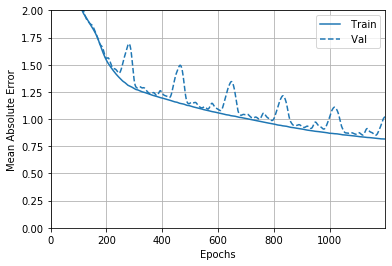

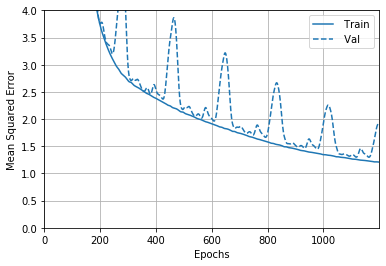

In [46]:
plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({"": history}, metric = "mae")
plt.ylim([0, 2])
plt.ylabel('Mean Absolute Error')

plt.figure()
plotter.plot({"": history}, metric = "mse")
plt.ylim([0, 4])
plt.ylabel('Mean Squared Error')

plt.show()

In [47]:
def average_distance_error(preds, y_test):
    return np.mean(np.sqrt(np.sum(np.square(preds - y_test), axis=2)))

1507/1 - 0s - loss: 2.4648 - mae: 1.0308 - mse: 1.9627
Test loss: 2.2564374250375283
Mean absolute error: 1.0307819
Mean squared error: 1.9627434
Average distance error: 1.6667715720776384


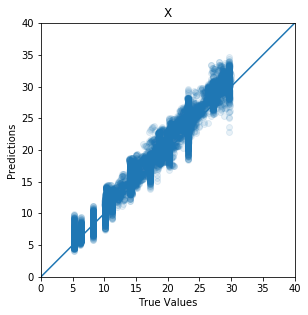

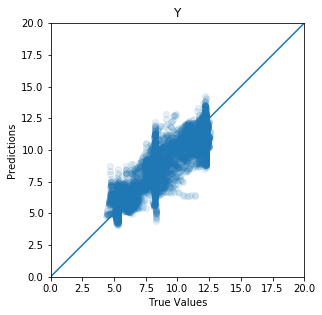

In [48]:
validation_scores = model.evaluate(X_validation, y_validation, verbose=2)
print("Test loss:", validation_scores[0])
print("Mean absolute error:", validation_scores[1])
print("Mean squared error:", validation_scores[2])

preds = model.predict(X_validation)
print("Average distance error:", average_distance_error(preds, y_validation))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, :, 0], preds[:, :, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_validation[:, :, 1], preds[:, :, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

1748/1 - 0s - loss: 7.3707 - mae: 1.4816 - mse: 3.9422
Test loss: 4.235908142761999
Mean absolute error: 1.4815983
Mean squared error: 3.9422147
Average distance error: 2.372585536748976


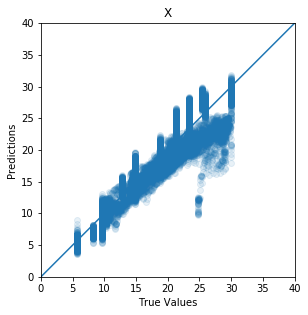

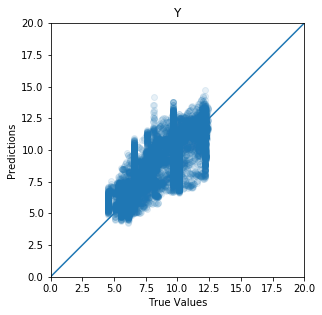

In [49]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Mean absolute error:", test_scores[1])
print("Mean squared error:", test_scores[2])

preds = model.predict(X_test)
print("Average distance error:", average_distance_error(preds, y_test))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_test[:, :, 0], preds[:, :, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_test[:, :, 1], preds[:, :, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

In [50]:
def cdf(preds, y_test):
    plt.figure(figsize=(10, 10))

    Z = np.sqrt(np.sum(np.square(preds - y_test), axis=2)).reshape(-1)
    N = Z.size

    X = np.sort(Z)
    F = np.array(range(N)) / float(N)
    plt.plot(X, F)
    plt.title('CDF of Euclidean Distance Error')
    plt.xlabel('Euclidean Distance Error (m)')
    plt.ylabel('Density')
    plt.show()

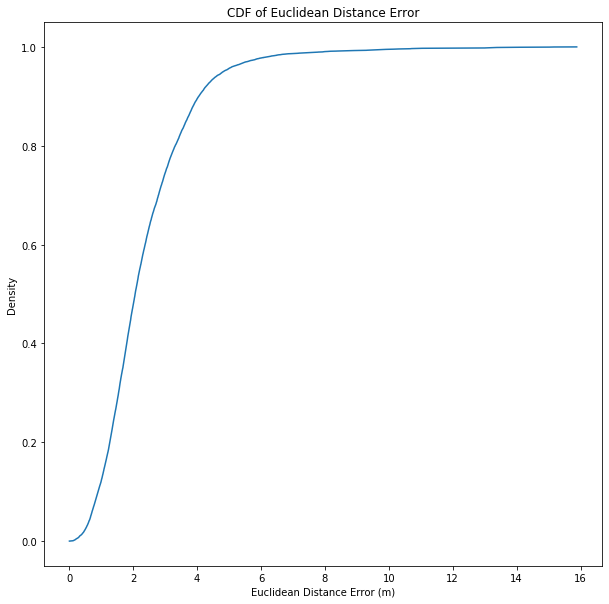

In [51]:
cdf(preds, y_test)